# Neural ODE

In [2]:
import jax
import jax.numpy as jnp
import jax.random as jr
from jax import vmap
import optax
import equinox as eqx
import diffrax
import jax.nn as jnn
import matplotlib.pyplot as plt
import time
from datetime import datetime

In [ ]:
def get_data(ts, y0):
    def beta(t):
        beta = lambda t: 0.025 * jnp.sin(2 * jnp.pi * t / 20) + 0.03
        return beta(t)

    def alpha(t):
        return 0.2

    def f(t, y, args=None):
        bb = beta(t)
        aa = alpha(t)
        S, I = y
        return jnp.array([-bb * S * I, bb * S * I - aa * I])

    sol = diffrax.diffeqsolve(
        diffrax.ODETerm(f),
        diffrax.Tsit5(),
        t0=0,
        t1=ts[-1],
        dt0=0.1,
        y0=y0,
        saveat=diffrax.SaveAt(ts=ts)
    )
    return ts, sol.ys


def relative_error(pred, true):
    return jnp.linalg.norm(pred - true, 2) / jnp.linalg.norm(true, 2)

In [42]:
class Func(eqx.Module):
    NN: eqx.nn.MLP

    def __init__(self, width_size, depth, *, key):
        self.NN = eqx.nn.MLP(2, 2, width_size, depth, activation=jnn.tanh, key=key)

    def __call__(self, t, y, arg=None):
        return self.NN(y)


class NeuralODE(eqx.Module):
    func: Func
    alpha: jnp.ndarray
    beta: eqx.nn.MLP

    def __init__(self, width_size, depth, *, key):
        key_func, key_alpha, key_beta = jr.split(key, 3)
        self.func = Func(width_size, depth, key=key_func)
        self.alpha = jnp.array(jr.uniform(key_alpha, (), minval=0.0, maxval=1.0))
        self.beta = eqx.nn.MLP(1,
            1,
            width_size,
            depth,
            activation=jnn.softplus,
            final_activation=lambda x: 0.1 * jnn.sigmoid(x),
            key=key_beta
            )

    def __call__(self, ts, y0):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=0,
            t1=ts[-1],
            dt0=0.01,
            y0=y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return self.alpha, self.beta, solution.ys

In [43]:
def main(
    lr=1e-3,
    t_data=jnp.linspace(0., 20., 20),
    t_ge=jnp.linspace(0., 20., 200),
    width_size=64,
    depth=2,
    seed=5678,
    steps=1000,
):
    key = jr.PRNGKey(seed)

    y0 = jnp.array([100.0, 1.0])
    t_data, y_data = get_data(t_data, y0)
    t_ge, y_ge = get_data(t_ge, y0)

    model = NeuralODE(width_size, depth, key=key)
    scheduler = optax.piecewise_constant_schedule(
        init_value=lr,
        boundaries_and_scales={10000: 0.1}
    )
    optim = optax.adam(learning_rate=scheduler)

    @eqx.filter_value_and_grad
    def grad_loss(model):
        _, _, pred_data = model(t_data, y0)
        data_loss = jnp.mean((pred_data - y_data) ** 2)

        pred_alpha, _, pred_ge = model(t_ge, y0)
        pred_beta=vmap(lambda t: model.beta(jnp.array([t])))(t_ge)
        pred_beta=jnp.squeeze(pred_beta)
        dydt = vmap(lambda y: model.func(t_ge, y))(pred_ge)
        dS = - pred_beta * pred_ge[:,0] * pred_ge[:,1]
        dI = pred_beta * pred_ge[:,0] * pred_ge[:,1] - pred_alpha * pred_ge[:,1]
        dSI = jnp.stack([dS, dI], axis=-1)
        ge_loss = jnp.mean((dydt - dSI) ** 2)
        return data_loss+ge_loss



    @eqx.filter_jit
    def make_step(model, opt_state):
        loss, grads = grad_loss(model)
        updates, opt_state = optim.update(grads, opt_state, value=loss)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
    loss_list = []
    alpha_list = []

    for step in range(steps):
        loss, model, opt_state = make_step(model, opt_state)
        loss_list.append(loss)
        alpha_list.append(float(model.alpha))

        if step % 100 == 0 or step == steps - 1:
            print(f"Step {step}, Loss: {loss:.4e}")

    return t_data, y_data, t_ge, y_ge, model, loss_list, alpha_list

In [44]:
t_data, y_data, t_ge, y_ge, model, loss_list, alpha_list = main(steps=20000)

Step 0, Loss: 5.5819e+03
Step 100, Loss: 1.0565e+03
Step 200, Loss: 6.8787e+02
Step 300, Loss: 5.0442e+02
Step 400, Loss: 3.8640e+02
Step 500, Loss: 3.0328e+02
Step 600, Loss: 2.4526e+02
Step 700, Loss: 2.0218e+02
Step 800, Loss: 1.7068e+02
Step 900, Loss: 1.4473e+02
Step 1000, Loss: 1.2334e+02
Step 1100, Loss: 1.0585e+02
Step 1200, Loss: 9.1472e+01
Step 1300, Loss: 8.0057e+01
Step 1400, Loss: 7.1021e+01
Step 1500, Loss: 6.3095e+01
Step 1600, Loss: 5.6657e+01
Step 1700, Loss: 5.1179e+01
Step 1800, Loss: 4.6343e+01
Step 1900, Loss: 4.2363e+01
Step 2000, Loss: 3.9355e+01
Step 2100, Loss: 3.6082e+01
Step 2200, Loss: 3.3800e+01
Step 2300, Loss: 3.1781e+01
Step 2400, Loss: 3.0377e+01
Step 2500, Loss: 2.8615e+01
Step 2600, Loss: 2.8202e+01
Step 2700, Loss: 2.6723e+01
Step 2800, Loss: 2.6277e+01
Step 2900, Loss: 2.5776e+01
Step 3000, Loss: 2.5038e+01
Step 3100, Loss: 2.2436e+01
Step 3200, Loss: 2.4363e+01
Step 3300, Loss: 2.3973e+01
Step 3400, Loss: 2.4013e+01
Step 3500, Loss: 2.3447e+01
Step

Text(0.5, 1.0, 'Training Loss')

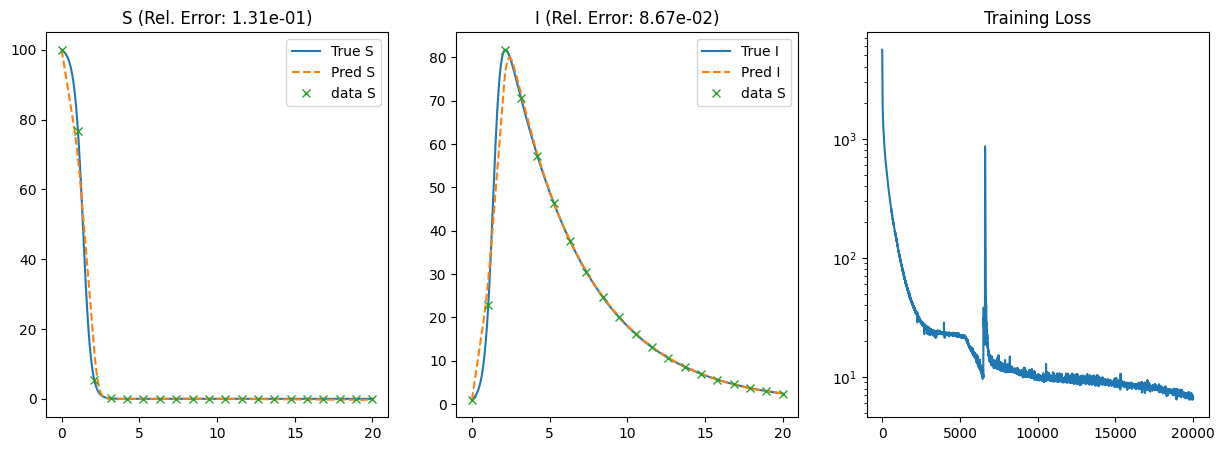

In [45]:
y0 = jnp.array([100.0, 1.0])
exact_ts, exact_ys = get_data(jnp.linspace(0, 20, 1000), y0)

eval_alpha, eval_beta, model_ys = model(exact_ts, y0)

rel_S = relative_error(model_ys[:, 0], exact_ys[:, 0])
rel_I = relative_error(model_ys[:, 1], exact_ys[:, 1])

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(exact_ts, exact_ys[:, 0], label="True S")
axs[0].plot(exact_ts, model_ys[:, 0], label="Pred S", linestyle="--")
# axs[0].plot(t_ge, y_ge[:, 0], label="ge S", linestyle="None", marker=".")
axs[0].plot(t_data, y_data[:, 0], label="data S", linestyle="None", marker="x")
axs[0].set_title(f"S (Rel. Error: {rel_S:.2e})")
axs[0].legend()

axs[1].plot(exact_ts, exact_ys[:, 1], label="True I")
axs[1].plot(exact_ts, model_ys[:, 1], label="Pred I", linestyle="--")
# axs[1].plot(t_ge, y_ge[:, 1], label="ge I", linestyle="None", marker=".")
axs[1].plot(t_data, y_data[:, 1], label="data S", linestyle="None", marker="x")
axs[1].set_title(f"I (Rel. Error: {rel_I:.2e})")
axs[1].legend()

axs[2].plot(loss_list)
axs[2].set_yscale("log")
axs[2].set_title("Training Loss")

alpha:0.19761894643306732


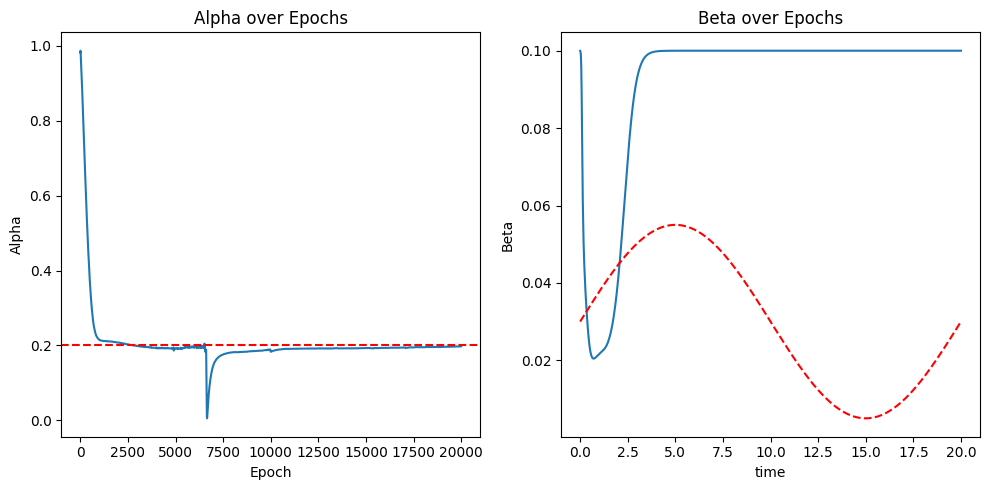

In [46]:
print(f'alpha:{eval_alpha}')

beta_list=vmap(lambda t: model.beta(jnp.array([t])))(exact_ts)
beta_list=jnp.squeeze(beta_list)

def beta(t):
    beta = lambda t: 0.025 * jnp.sin(2 * jnp.pi * t / 20) + 0.03
    return beta(t)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# alpha 변화 그래프
axs[0].plot(alpha_list)
axs[0].axhline(0.2, color='red', linestyle='--', label="True Alpha")
axs[0].set_title("Alpha over Epochs")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Alpha")

# beta 변화 그래프
axs[1].plot(exact_ts, beta_list)
axs[1].plot(exact_ts, beta(exact_ts), color='red', linestyle='--', label="True beta")
axs[1].set_title("Beta over Epochs")
axs[1].set_xlabel("time")
axs[1].set_ylabel("Beta")

plt.tight_layout()
plt.show()